In [4]:
import numpy as np
import pandas as pd
import scipy
import scipy.io

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',**{'fontsize':12})
from skimage.transform import resize
from skimage.io import imsave

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from IPython.display import clear_output

##### OSM related ######
import math
import overpass

import copy as cp 

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

## Construct bounding box class

This is used for extracting osm map tile according to overpass api 

In [5]:
class BoundingBox(object):
    def __init__(self, *args, **kwargs):
        self.lat_min = None
        self.lon_min = None
        self.lat_max = None
        self.lon_max = None


def get_bounding_box_in_mile(latitude_in_degrees, longitude_in_degrees, half_side_in_miles):
    assert half_side_in_miles > 0
    assert latitude_in_degrees >= -90.0 and latitude_in_degrees  <= 90.0
    assert longitude_in_degrees >= -180.0 and longitude_in_degrees <= 180.0

    half_side_in_km = half_side_in_miles * 1.609344
    lat = math.radians(latitude_in_degrees)
    lon = math.radians(longitude_in_degrees)

    radius  = 6371
    # Radius of the parallel at given latitude
    parallel_radius = radius*math.cos(lat)

    lat_min = lat - half_side_in_km/radius
    lat_max = lat + half_side_in_km/radius
    lon_min = lon - half_side_in_km/parallel_radius
    lon_max = lon + half_side_in_km/parallel_radius
    rad2deg = math.degrees

    box = BoundingBox()
    box.lat_min = rad2deg(lat_min)
    box.lon_min = rad2deg(lon_min)
    box.lat_max = rad2deg(lat_max)
    box.lon_max = rad2deg(lon_max)

    return (box)


def get_bounding_box_in_km(latitude_in_degrees, longitude_in_degrees, half_side_in_km):
    assert half_side_in_km > 0
    assert latitude_in_degrees >= -90.0 and latitude_in_degrees  <= 90.0
    assert longitude_in_degrees >= -180.0 and longitude_in_degrees <= 180.0

    half_side_in_km = half_side_in_km * 1.0
    lat = math.radians(latitude_in_degrees)
    lon = math.radians(longitude_in_degrees)

    radius  = 6371
    # Radius of the parallel at given latitude
    parallel_radius = radius*math.cos(lat)

    lat_min = lat - half_side_in_km/radius
    lat_max = lat + half_side_in_km/radius
    lon_min = lon - half_side_in_km/parallel_radius
    lon_max = lon + half_side_in_km/parallel_radius
    rad2deg = math.degrees

    box = BoundingBox()
    box.lat_min = rad2deg(lat_min)
    box.lon_min = rad2deg(lon_min)
    box.lat_max = rad2deg(lat_max)
    box.lon_max = rad2deg(lon_max)

    return (box)

In [6]:
%%latex 
read in the response file of Afrobarometer

<IPython.core.display.Latex object>

In [7]:
file_p = "../data/es262-infrastructure-b-01/Afrobarometer_R6.csv"
afrob_df=pd.read_csv(file_p)

In [8]:
sub_df = afrob_df[['latitude', 'longitude', 'id']]
api = overpass.API()

In [27]:
import time 
import requests

## Extract the osm map tile information 

In [16]:
sub_df.shape[0]

7022

In [28]:
def extract_building_Hwy_from_osm_tile(idx_start, idx_end, sub_dataframe, verbose=False):
    # reading in the sub_dataframe
    n_rows = sub_df.shape[0]
    idx_end = int(np.min([idx_end, n_rows]))
    collection_mat = []
    for i in range(idx_start, idx_end):
        #         if i > 5: break
        _id = sub_dataframe.loc[i, "id"]
        #     collect_hwy = []
        # notice median resolution has 30meters per pixel 500*30 = 15km  
        k = 2.0 
        #if i > 3 : break
        lat_ = (sub_dataframe.loc[i, "latitude"])
        lng_ = (sub_dataframe.loc[i, "longitude"])
        box = get_bounding_box_in_km(lat_, lng_, k)
        map_query2 = overpass.MapQuery(np.round(box.lat_min, 5), np.round(box.lon_min, 5), np.round(box.lat_max, 5), np.round(box.lon_max,5) )
        try:
            response2 = api.Get(map_query2)
            
        except (requests.ConnectTimeout, requests.HTTPError, requests.ReadTimeout, requests.Timeout):
            time.sleep(6.0)
            response2 = api.Get(map_query2)
        except (requests.ConnectionError):
            print("exception!!")
            time.sleep(6.0)
            continue
        except (Exception):
            print("Final Error!!")
            continue
        #  show the result of response2
        #  display(response2)
        time.sleep(8.0)
        tmp_bd_count = 0
        tmp_hwy_count = 0 
        for collectted_dict in (response2["features"]):
            if "building" in collectted_dict["properties"].keys() : #"highway"
                if tmp_bd_count < 1 and verbose is True:    
                    print(collectted_dict["properties"])
                tmp_bd_count +=1 
            if "highway" in collectted_dict["properties"].keys() : #"highway"
                if tmp_hwy_count < 1 and verbose is True:
                    print(collectted_dict["properties"])
                tmp_hwy_count +=1     

        collection_mat.append([_id, k, tmp_bd_count, tmp_hwy_count, np.round(lat_, 5), np.round(lng_, 5)])
        # check 
        if i % 10 == 0 :
            print(collection_mat[(i-10):i])
        
    return collection_mat

In [29]:
osm_mat_0_50 = extract_building_Hwy_from_osm_tile(0, 50, sub_df)

[]
[[1, 2.0, 458, 1689, 34.672789999999999, 3.2629999999999999], [2, 2.0, 1382, 161, 6.94672, 1.70204], [3, 2.0, 2990, 653, -25.467120000000001, 25.439209999999999], [4, 2.0, 0, 1, 13.1753, -3.9298000000000002], [5, 2.0, 5573, 407, 6.4650400000000001, 12.62843], [6, 2.0, 8457, 1252, 5.2971599999999999, -3.96753], [7, 2.0, 59, 63, 29.841439999999999, 31.300840000000001], [8, 2.0, 0, 3, 0.246, 10.351000000000001], [9, 2.0, 0, 187, -18.96049, 47.566130000000001], [10, 2.0, 164, 53, 14.449999999999999, -11.37083]]
[[11, 2.0, 0, 4, 34.956659999999999, -3.76227], [12, 2.0, 926, 90, -12.342599999999999, 40.585900000000002], [13, 2.0, 83, 229, 16.98, 7.96], [14, 2.0, 0, 172, 5.1065800000000001, 7.3666700000000001], [15, 2.0, 11061, 2324, 14.769500000000001, -17.39115], [16, 2.0, 856, 2319, 36.80133, 10.18534], [17, 2.0, 0, 0, 34.333329999999997, 3.6666699999999999], [18, 2.0, 7, 17, 6.9738499999999997, 2.0251000000000001], [19, 2.0, 0, 5, -25.562899999999999, 25.55678], [20, 2.0, 0, 9, 13.1691

In [32]:
osm_file_df1 = pd.DataFrame(osm_mat_0_50, columns=["id", "half_km", "building_cnt", "hwy_cnt", "lat", "lng"])

In [33]:
osm_file_df1.to_csv("OSM_Af_folder/file0_50.csv", index=False)

### Run in for loop to save records in small patch files (every 50 survey records)

In [ ]:
for k in range(1, 100):
    j_start = k * 50
    j_end = (k+1)*50
    osm_mat_per_50 = extract_building_Hwy_from_osm_tile(j_start, j_end, sub_df)
    osm_file_df_ = pd.DataFrame(osm_mat_per_50, columns=["id", "half_km", "building_cnt", "hwy_cnt", "lat", "lng"])
    osm_file_df_.to_csv("OSM_Af_folder/file%d_50.csv" % k, index=False )

In [34]:
# pd.DataFrame(collection_mat)

## extract the OSM files into Dataframe

In [41]:
fnames=os.listdir("OSM_Af_folder/OSM_Af_folder/")

In [305]:
df_mat = None 
for i in range(141):
    df_ = pd.read_csv("OSM_Af_folder/OSM_Af_folder/file%d_50.csv" %i)
    print(df_.head(2))
    if df_mat is None:
        df_mat = df_
    else:
        df_mat = pd.concat((df_mat, df_), axis=0 )

   id  half_km  building_cnt  hwy_cnt       lat      lng
0   1      2.0           458     1689  34.67279  3.26300
1   2      2.0          1382      161   6.94672  1.70204
   id  half_km  building_cnt  hwy_cnt      lat       lng
0  51      2.0             2        6  13.2017  -4.17760
1  52      2.0            21       28   6.5000  13.26667
    id  half_km  building_cnt  hwy_cnt       lat       lng
0  101      2.0             2      121   0.38500   9.51000
1  102      2.0             0        0 -13.96667  48.11667
    id  half_km  building_cnt  hwy_cnt       lat       lng
0  151      2.0             0      187 -18.96049  47.56613
1  152      2.0             0        4  14.50950  -9.90990
    id  half_km  building_cnt  hwy_cnt       lat       lng
0  201      2.0             0       33  12.66854 -11.13893
1  202      2.0           304      235  31.65869  -7.96217
    id  half_km  building_cnt  hwy_cnt       lat       lng
0  251      2.0          1348     2132  31.63627  -7.98512
1  252   

     id  half_km  building_cnt  hwy_cnt       lat       lng
0  2601      2.0             5      142   7.81667   4.48333
1  2602      2.0            35      229 -15.59722  34.44750
     id  half_km  building_cnt  hwy_cnt       lat       lng
0  2651      2.0             0       18   4.78741   7.14369
1  2652      2.0             0        1 -17.20528  38.06583
     id  half_km  building_cnt  hwy_cnt     lat     lng
0  2701      2.0             0        4   6.800  11.050
1  2702      2.0             0        0 -16.789  38.465
     id  half_km  building_cnt  hwy_cnt     lat     lng
0  2751      2.0             0        0  15.874  32.824
1  2752      2.0             0        0  15.800  33.000
     id  half_km  building_cnt  hwy_cnt       lat       lng
0  2801      2.0             0        0  11.26667  30.83333
1  2802      2.0             0        1  12.58840  31.27910
     id  half_km  building_cnt  hwy_cnt      lat     lng
0  2851      2.0            64       41  6.48222 -10.405
1  2852   

     id  half_km  building_cnt  hwy_cnt       lat       lng
0  5051      2.0             0      181 -27.20588  25.95871
1  5052      2.0             3       29 -17.00388  13.24825
     id  half_km  building_cnt  hwy_cnt       lat       lng
0  5101      2.0             0      245 -26.22671  28.47265
1  5102      2.0             0      245 -26.22671  28.47265
     id  half_km  building_cnt  hwy_cnt       lat       lng
0  5152      2.0            60      612 -26.12862  27.93051
1  5153      2.0            40      702 -26.19380  28.10612
     id  half_km  building_cnt  hwy_cnt       lat       lng
0  5201      2.0            41      404 -25.70870  28.28335
1  5202      2.0           191      335 -25.67629  28.21987
     id  half_km  building_cnt  hwy_cnt       lat       lng
0  5251      2.0             0      206 -25.76751  29.39976
1  5252      2.0           448       52 -29.50000  28.25000
     id  half_km  building_cnt  hwy_cnt       lat       lng
0  5301      2.0             0        1 

In [306]:
# df_mat
nomed_response_wID_mat = pd.read_csv("cs325b-infrastructure/process-data/Af_normed_response_mat_wID.csv")

In [307]:
osm_merged_response_df = pd.merge(df_mat, nomed_response_wID_mat, left_on="id", right_on="id")

In [308]:
print(osm_merged_response_df.shape)
osm_merged_response_df.columns

(6833, 40)


Index(['id', 'half_km', 'building_cnt', 'hwy_cnt', 'lat', 'lng',
       'eaelectricity', 'eapipedwater', 'easewage', 'eacellphone',
       'eapostoffice', 'easchool', 'eapolicestation', 'eahealthclinic',
       'eamarketstalls', 'eabank', 'earoad', 'eateacherservices',
       'eamedicalservices', 'eahouseholdservices', 'eapoliceservices',
       'eadocumentservices', 'eacourtservices', 'eametalroof', 'eagrassroof',
       'eatileroof', 'eaformalhouse', 'eatraditionalhouse', 'eaflat',
       'eanofood', 'eanowater', 'eanomedicine', 'eanofuel', 'eanocash',
       'eaage', 'eaeducationlevel', 'ealivingconditions',
       'earelativelivingconditions', 'eaownradio', 'eaowntelevision'],
      dtype='object')

In [309]:
afrob_df.shape

(7022, 56)

In [176]:
# for col_name in osm_merged_response_df.columns[6:]: 
#     plt.figure()
#     plt.scatter(osm_merged_response_df["hwy_cnt"], osm_merged_response_df[col_name])
#     plt.title(col_name)
#     plt.show()

In [129]:
# for col_name in osm_merged_response_df.columns[6:]: 
#     plt.figure()
#     plt.scatter(osm_merged_response_df["building_cnt"]+osm_merged_response_df["hwy_cnt"], osm_merged_response_df[col_name])
#     plt.title(col_name)
#     plt.show()

In [310]:
from sklearn import preprocessing

In [311]:
std_scale = preprocessing.MinMaxScaler().fit(osm_merged_response_df["building_cnt"].values)

/home/xchen/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/xchen/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [312]:
std_hwy_scale = preprocessing.MinMaxScaler().fit(osm_merged_response_df["hwy_cnt"].values)

/home/xchen/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/xchen/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [313]:
std_bd_log_scale = preprocessing.MinMaxScaler().fit(np.log(osm_merged_response_df["building_cnt"].values +1))
std_hwy_log_scale = preprocessing.MinMaxScaler().fit(np.log(osm_merged_response_df["hwy_cnt"].values +1))

/home/xchen/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/xchen/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [130]:
# plt.hist(std_scale.transform(osm_merged_response_df["building_cnt"].values), bins=200)

In [131]:
# for col_name in osm_merged_response_df.columns[6:]:  
#     plt.figure()
    
        
# #     #     plt.hist(afrob_df[col_name].dropna().values, bins=200)
# #     plt.show()
#     correff = scipy.stats.pearsonr((std_hwy_scale.transform(osm_merged_response_df["hwy_cnt"].values)+1) / (std_scale.transform(osm_merged_response_df["building_cnt"].values)+1), osm_merged_response_df[col_name])
                         
#     print(col_name + ":%.5f" % correff[0])
#     plt.title(col_name + "\n corr:%.5f" % correff[0])
#     plt.scatter((std_hwy_scale.transform(osm_merged_response_df["hwy_cnt"].values)+1) / (std_scale.transform(osm_merged_response_df["building_cnt"].values)+1), osm_merged_response_df[col_name])
#     plt.show()

In [132]:
# plt.hist(np.log(1+std_scale.transform(osm_merged_response_df["building_cnt"].values)))

In [133]:
# for col_name in osm_merged_response_df.columns[6:]: 
#     plt.figure()
#     plt.scatter(np.log(1+std_scale.transform(osm_merged_response_df["building_cnt"].values)), osm_merged_response_df[col_name])
#     plt.title(col_name)
#     plt.show()

In [105]:
# plt.hist((std_hwy_scale.transform(osm_merged_response_df["hwy_cnt"].values)+1) / (std_scale.transform(osm_merged_response_df["building_cnt"].values)+1) - 1, bins=100 )

In [314]:
ratio_hwy_over_bd=(std_hwy_scale.transform(osm_merged_response_df["hwy_cnt"].values)+1) / (std_scale.transform(osm_merged_response_df["building_cnt"].values)+1) - 1 

# ratio_bd_multi_hwy=(std_scale.transform(osm_merged_response_df["building_cnt"].values)) * (std_hwy_scale.transform(osm_merged_response_df["hwy_cnt"].values))

/home/xchen/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/xchen/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [315]:
normed_hwy_cnt = std_hwy_scale.transform(osm_merged_response_df["hwy_cnt"].values)
normed_bd_cnt = std_scale.transform(osm_merged_response_df["building_cnt"].values)
normed_log_bd_cnt = std_bd_log_scale.transform(np.log(osm_merged_response_df["building_cnt"].values +1))
normed_log_hwy_cnt = std_hwy_log_scale.transform(np.log(osm_merged_response_df["hwy_cnt"].values +1))

/home/xchen/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/xchen/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/xchen/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either u

In [316]:
X_mat = np.transpose(np.vstack((ratio_hwy_over_bd, normed_hwy_cnt, normed_bd_cnt, 
                                np.sqrt(normed_bd_cnt), np.sqrt(normed_hwy_cnt), normed_log_bd_cnt )))

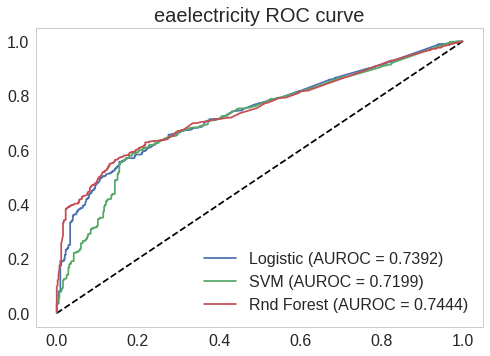

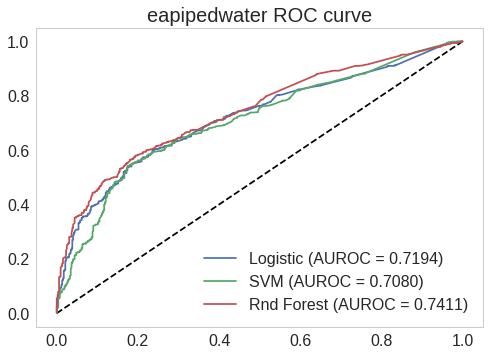

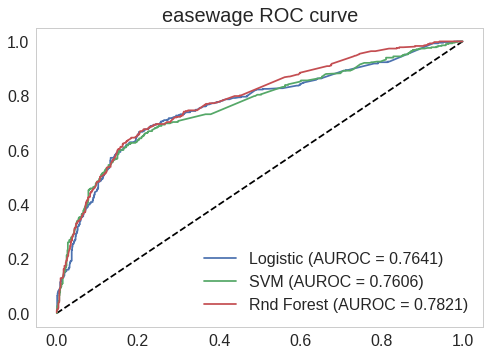

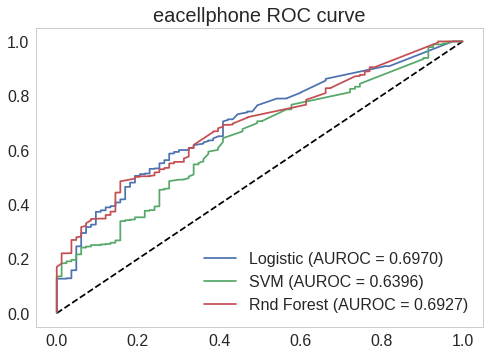

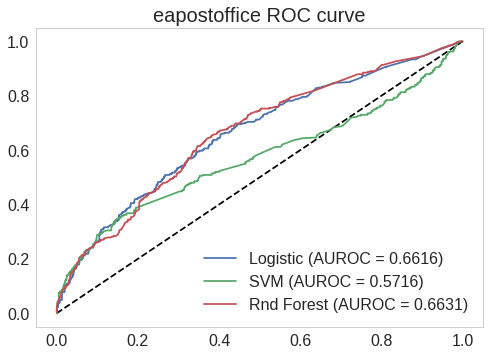

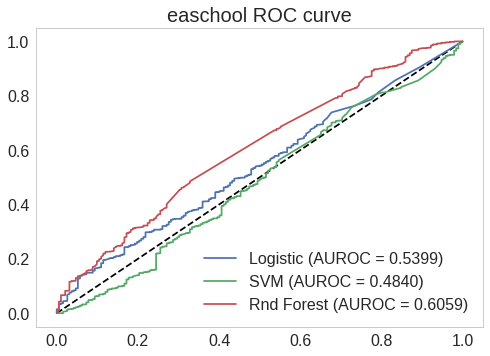

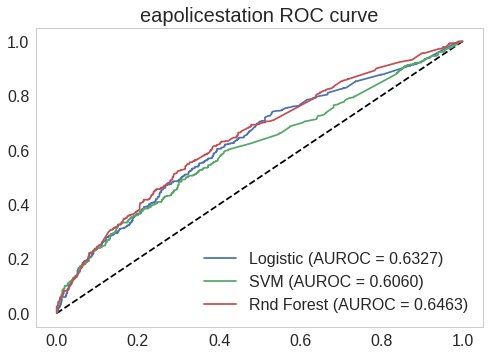

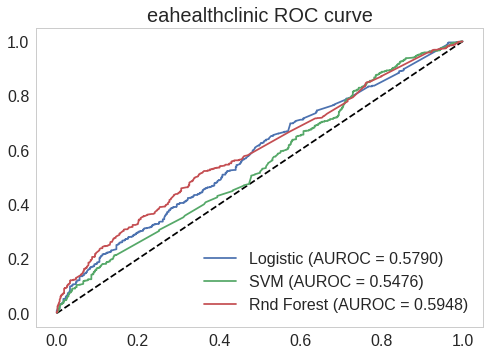

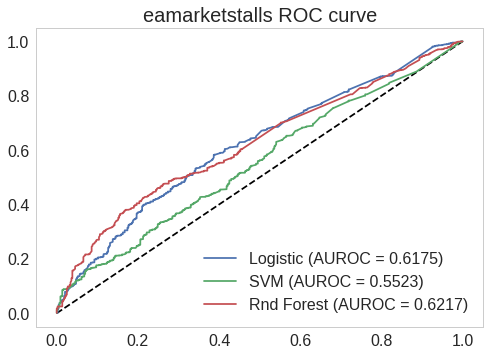

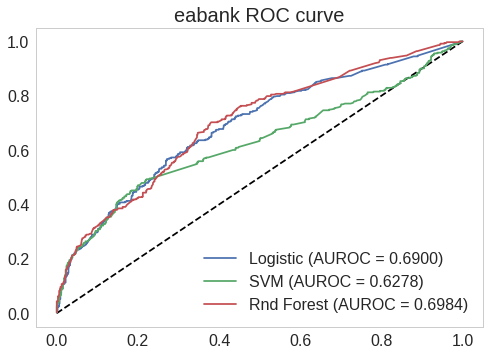

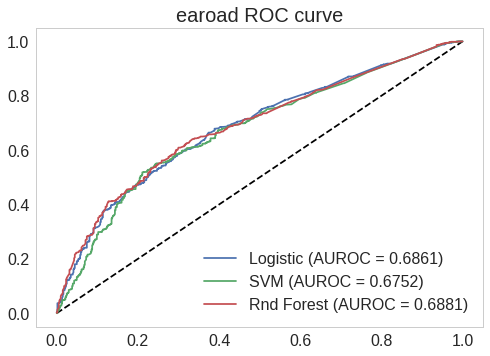

In [318]:
# from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split




lr = linear_model.LinearRegression()
logi_r = linear_model.LogisticRegression(C=1)
# boston = datasets.load_boston()

svm_clf = svm.SVC(probability=True, C=100, kernel='rbf', gamma=5)
# svm_clf = svm.SVC(probability=True, C=100, kernel='poly', degree=2)
rnd_f_clf = RandomForestClassifier(max_depth=5, n_estimators=20, max_features=1, random_state=3)



for col_name in osm_merged_response_df.columns[6:17]: 
    y = osm_merged_response_df[col_name].values
    X_mat_train, X_mat_test, y_train, y_test = train_test_split(X_mat, y, test_size=.2, random_state=3) 
    # cross_val_predict returns an array of the same size as `y` where each entry
    # is a prediction obtained by cross validation:
    #     predicted = cross_val_predict(logi_r, X_mat, y, cv=10)
    logi_r.fit(X_mat_train, y_train)
    svm_clf.fit(X_mat_train, y_train)
    rnd_f_clf.fit(X_mat_train, y_train)
    y_pred_rt = logi_r.predict_proba(X_mat_test)[:, 1]
    y_pred_rt_svm = svm_clf.predict_proba(X_mat_test)[:,1]
    y_pred_rt_rnd = rnd_f_clf.predict_proba(X_mat_test)[:,1]
    fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
    fpr_rt_svm, tpr_rt_svm, _s = roc_curve(y_test, y_pred_rt_svm)
    fpr_rt_rnd, tpr_rt_rnd, _rndf = roc_curve(y_test, y_pred_rt_rnd)
    auroc_lm = auc(fpr_rt_lm, tpr_rt_lm)
    auroc_svm = auc(fpr_rt_svm, tpr_rt_svm)
    auroc_rndf = auc(fpr_rt_rnd, tpr_rt_rnd)
    
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rt_lm, tpr_rt_lm, label = "Logistic (AUROC = %.4f)" % auroc_lm )
    plt.plot(fpr_rt_svm, tpr_rt_svm, label = "SVM (AUROC = %.4f)" % auroc_svm )
    plt.plot(fpr_rt_rnd, tpr_rt_rnd, label = "Rnd Forest (AUROC = %.4f)" % auroc_rndf )
    
    plt.legend(fontsize=16)
    plt.title(col_name+" ROC curve", fontsize=20)
    plt.tick_params(labelsize=16)
    plt.show()
    
    
#     fig, ax = plt.subplots()
#     ax.scatter(y, predicted, edgecolors=(0, 0, 0))
#     ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
#     ax.set_xlabel('Measured')
#     ax.set_ylabel('Predicted')
#     ax.set_title(col_name + "\n $R^2 = $ %.4f" % r2_score(y, predicted) )
#     plt.show()

#     X_mat.shape

eaelectricity
             precision    recall  f1-score   support

        0.0       0.53      0.22      0.31       454
        1.0       0.70      0.90      0.79       913

avg / total       0.65      0.68      0.63      1367

eapipedwater
             precision    recall  f1-score   support

        0.0       0.56      0.59      0.57       522
        1.0       0.74      0.71      0.72       845

avg / total       0.67      0.67      0.67      1367

easewage
             precision    recall  f1-score   support

        0.0       0.78      0.91      0.84       949
        1.0       0.67      0.43      0.53       418

avg / total       0.75      0.76      0.75      1367

eacellphone
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        83
        1.0       0.94      1.00      0.97      1284

avg / total       0.88      0.94      0.91      1367

eapostoffice
             precision    recall  f1-score   support

        0.0       0.75   

/home/xchen/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


eamarketstalls
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00       442
        1.0       0.68      1.00      0.81       925

avg / total       0.46      0.68      0.55      1367

eabank
             precision    recall  f1-score   support

        0.0       0.77      0.96      0.86      1004
        1.0       0.67      0.21      0.33       363

avg / total       0.74      0.76      0.72      1367

earoad
             precision    recall  f1-score   support

        0.0       0.58      0.64      0.61       607
        1.0       0.69      0.64      0.66       760

avg / total       0.64      0.64      0.64      1367



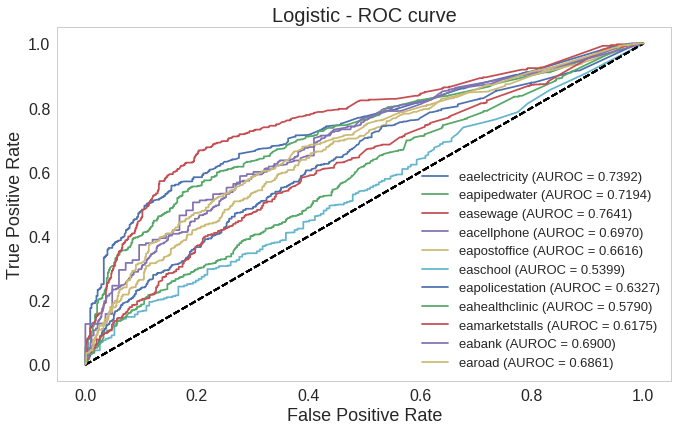

In [317]:
# confusion matrix 
from sklearn.metrics import confusion_matrix, classification_report




plt.figure(figsize=(11,6.5))

for col_name in osm_merged_response_df.columns[6:17]: 
    y = osm_merged_response_df[col_name].values
    X_mat_train, X_mat_test, y_train, y_test = train_test_split(X_mat, y, test_size=.2, random_state=3) 
    # cross_val_predict returns an array of the same size as `y` where each entry
    # is a prediction obtained by cross validation:
    #     predicted = cross_val_predict(logi_r, X_mat, y, cv=10)
    logi_r.fit(X_mat_train, y_train)
#     svm_clf.fit(X_mat_train, y_train)
#     rnd_f_clf.fit(X_mat_train, y_train)
    y_pred_rt = logi_r.predict_proba(X_mat_test)[:, 1]
    y_pred_lables = logi_r.predict(X_mat_test)
#     y_pred_rt_svm = svm_clf.predict_proba(X_mat_test)[:,1]
#     y_pred_rt_rnd = rnd_f_clf.predict_proba(X_mat_test)[:,1]
    fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
#     fpr_rt_svm, tpr_rt_svm, _s = roc_curve(y_test, y_pred_rt_svm)
#     fpr_rt_rnd, tpr_rt_rnd, _rndf = roc_curve(y_test, y_pred_rt_rnd)
    auroc_lm = auc(fpr_rt_lm, tpr_rt_lm)
#     auroc_svm = auc(fpr_rt_svm, tpr_rt_svm)
#     auroc_rndf = auc(fpr_rt_rnd, tpr_rt_rnd)
    
#     plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rt_lm, tpr_rt_lm, label = col_name + " (AUROC = %.4f)" % auroc_lm )
#     plt.plot(fpr_rt_svm, tpr_rt_svm, label = "SVM (AUROC = %.4f)" % auroc_svm )
#     plt.plot(fpr_rt_rnd, tpr_rt_rnd, label = col_name+"Rnd Forest (AUROC = %.4f)" % auroc_rndf )
    
    plt.legend(fontsize=13)
    plt.title("Logistic - ROC curve", fontsize=20)
    plt.tick_params(labelsize=16)
    plt.ylabel("True Positive Rate", fontsize=18)
    plt.xlabel("False Positive Rate", fontsize=18)
    print(col_name)
    print(classification_report(y_test, y_pred_lables))
    
#     plt.show()

In [10]:
collection_mat = dict()
for i in range(sub_df.shape[0]):
    if i > 5: break
    _id = sub_df.loc[i, "id"]
    collect_hwy = []
    for k in range(1, 2):
        # notice median resolution has 
        k = np.round(k*1, 3)
        #if i > 3 : break
        lat_ = (sub_df.loc[i, "latitude"])
        lng_ = (sub_df.loc[i, "longitude"])
        box = get_bounding_box_in_km(lat_, lng_, k)
        map_query2 = overpass.MapQuery(np.round(box.lat_min, 5), np.round(box.lon_min, 5), np.round(box.lat_max, 5), np.round(box.lon_max,5) )
        response2 = api.Get(map_query2)
#         response2
        display(response2)
        time.sleep(6.0)
        tmp_count = 0
        for collectted_dict in (response2["features"]):
            if "building" in collectted_dict["properties"].keys() : #"highway"
                print(collectted_dict["properties"])
                tmp_count +=1 
                
        collect_hwy.append([k, tmp_count])
        
    collection_mat[_id]= collect_hwy

{"features": [{"geometry": {"coordinates": [3.254037, 34.671359], "type": "Point"}, "id": 299681006, "properties": {"capital": "4", "ele": "1205", "is_in": "Djelfa, Djelfa, Algeria", "is_in:continent": "Africa", "is_in:country": "Algeria", "is_in:country_code": "DZ", "name": "Djelfa", "name:ar": "\u0627\u0644\u062c\u0644\u0641\u0629", "name:ber": "\u2d35\u2d3b\u2d4d\u2d3c\u2d30", "name:de": "Djelfa", "name:en": "Djelfa", "name:es": "Djelfa", "name:fa": "\u0627\u0644\u062c\u0641\u0644\u0647", "name:fr": "Djelfa", "name:it": "Djelfa", "name:ja": "\u30b8\u30a7\u30eb\u30d5\u30a1", "name:kab": "\u01e6elfa", "name:ko": "\uc824\ud30c", "name:lt": "D\u017eelfa", "name:nl": "Djelfa", "name:pl": "D\u017cilfa", "name:ru": "\u0414\u0436\u0435\u043b\u044c\u0444\u0430", "name:uk": "\u0414\u0436\u0435\u043b\u044c\u0444\u0430", "name:zh": "\u6770\u52d2\u6cd5", "place": "city", "population": "289226", "population:date": "2008", "ref:ONS": "1701", "wikidata": "Q2794758", "wikipedia": "fr:Djelfa"}, "type

{'brand': 'NAFTAL', 'name': 'محطة بنزين', 'building': 'yes', 'name:ar': 'محطة بنزين', 'amenity': 'fuel'}
{'fixme': 'Merci de préciser le nom de la mosquée', 'name': 'مسجد', 'building': 'mosque', 'religion': 'muslim', 'denomination': 'sunni', 'amenity': 'place_of_worship', 'name:ar': 'مسجد'}
{'name': 'Marché couvert central (legumes et fruits)', 'building': 'retail', 'shop': 'greengrocer'}
{'name': 'Mosquée Sidi nail', 'building': 'yes', 'religion': 'muslim', 'denomination': 'sunni', 'amenity': 'place_of_worship', 'name:ar': 'مسجد سيدي نايل'}
{'website': 'www.poste.dz', 'wikipedia': 'fr:Algérie Poste', 'building': 'yes', 'operator': 'Algérie Poste', 'email': 'clientalgerieposte@poste.dz', 'name:en': 'Post office', 'source': 'Algerie Mapper Team', 'name': 'Ancien bureau de poste de Djelfa', 'amenity': 'post_office', 'building:levels': '2', 'addr:street': 'Avenue Emir Abdelkader', 'addr:postcode': '17000', 'addr:city': 'Djelfa', 'fax': '021735496'}
{'name:en': 'El Amir', 'building': 'yes'

{"features": [{"geometry": {"coordinates": [1.7041012, 6.9489244], "type": "Point"}, "id": 496264781, "properties": {"is_in": "Benin", "name": "Aplahou\u00e9", "name:ru": "\u0410\u043f\u043b\u0430\u0445\u0443\u044d", "name:uk": "\u0410\u043f\u043b\u0430\u0445\u0443\u0435", "place": "city", "population": "170000", "source": "Perry-Casta\u00f1eda LibraryMap Collection"}, "type": "Feature"}, {"geometry": {"coordinates": [1.702499, 6.947924], "type": "Point"}, "id": 746970106, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [1.702682, 6.947142], "type": "Point"}, "id": 895569180, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [1.70292, 6.946996], "type": "Point"}, "id": 895569215, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [1.702527, 6.947492], "type": "Point"}, "id": 895569230, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [1.704632, 6.946268], "type": "Point"}, "id": 895569280, "properties": {}, "type": "

{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building': 'yes', 'source': 'Bing'}
{'building':

{"features": [{"geometry": {"coordinates": [25.4474963, -25.4681089], "type": "Point"}, "id": 1797873040, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [25.4399478, -25.4725743], "type": "Point"}, "id": 1797873053, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [25.43671, -25.472936], "type": "Point"}, "id": 2469660338, "properties": {"name": "Good Hope", "place": "village", "wikidata": "Q170872", "wikipedia": "en:Good Hope (Botswana)"}, "type": "Feature"}, {"geometry": {"coordinates": [25.4386965, -25.4706986], "type": "Point"}, "id": 2503398587, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [25.4378772, -25.4695753], "type": "Point"}, "id": 2503398588, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [25.4364687, -25.4680458], "type": "Point"}, "id": 2503398589, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [25.4351244, -25.466494], "type": "Point"}, "id": 2503398590, "properties": {}

{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}


{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'hut'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}


{"features": [{"geometry": {"coordinates": [-3.9287815, 13.1750998], "type": "Point"}, "id": 902983600, "properties": {"admin_level": "8", "capital": "8", "is_in": "Barani;Kossi;Boucle du Mouhoun;Burkina Faso;Africa", "is_in:continent": "Africa", "is_in:country": "Burkina Faso", "is_in:country_code": "BF", "is_in:department": "Barani", "is_in:province": "Kossi", "is_in:province_code": "13", "is_in:region": "Boucle du Mouhoun", "is_in:region_code": "02", "name": "Diallo", "name:fr": "Diallo", "place": "village", "population": "545", "population:date": "2012", "source": "NGA GEOnet Names Server (GNS)"}, "type": "Feature"}, {"geometry": {"coordinates": [-3.9281417, 13.172594], "type": "Point"}, "id": 2205434465, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-3.9279164, 13.1726893], "type": "Point"}, "id": 2205434471, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-3.9274464, 13.1730874], "type": "Point"}, "id": 2205434474, "properties": {}, "type

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}


{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}


{"features": [{"geometry": {"coordinates": [-3.9738522, 5.3046814], "type": "Point"}, "id": 24268443, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-3.9588686, 5.3053415], "type": "Point"}, "id": 24288977, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-3.9640939, 5.3057154], "type": "Point"}, "id": 24288992, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-3.9690286, 5.3055136], "type": "Point"}, "id": 24288997, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-3.9718087, 5.3053321], "type": "Point"}, "id": 24289261, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-3.9712365, 5.2899465], "type": "Point"}, "id": 33320941, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-3.9721999, 5.2908451], "type": "Point"}, "id": 33320942, "properties": {}, "type": "Feature"}, {"geometry": {"coordinates": [-3.9716795, 5.2904795], "type": "Point"}, "id": 338990980, "properties": {

{'name': "Paroisse Saint François d'Assise", 'building': 'yes', 'religion': 'christian', 'denomination': 'catholic', 'amenity': 'place_of_worship'}
{'name': 'Paroisse Saint Etienne de Koumassi', 'building': 'yes', 'religion': 'christian', 'denomination': 'catholic', 'amenity': 'place_of_worship'}
{'name': 'Residence Nama', 'building': 'yes'}
{'name': 'Residence Boubou-Do-Makhan', 'building': 'yes'}
{'brand': 'Total', 'addr:country': 'CI', 'building': 'yes', 'operator': "Total Côte d'Ivoire SA", 'amenity': 'fuel', 'name': 'Station Service Total Boulevard du 7 Décembre', 'addr:state': 'Abidjan'}
{'name': 'Grande mosquée de Koumassi', 'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'name': 'Église des Assemblés de Dieu', 'building': 'yes', 'religion': 'christian', 'amenity': 'place_of_worship'}
{'name': 'Lycee Moderne De Koumassi', 'buildi

{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}
{'building': 'yes'}


In [11]:
collection_mat

{1: [(1, 112)],
 2: [(1, 969)],
 3: [(1, 1464)],
 4: [(1, 0)],
 5: [(1, 3899)],
 6: [(1, 2158)]}

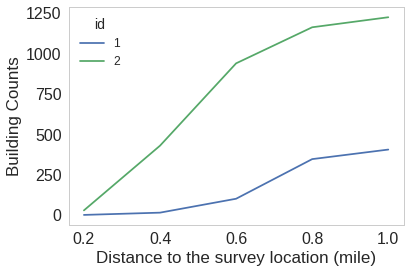

In [14]:
for k in range(1,3):
    x = []
    y = []
    for a, b in (collection_mat[k]):
        x.append(a)
        y.append(b)

    plt.plot(x,y, label="%d"%k)
    plt.xlabel("Distance to the survey location (mile)", fontsize=17)
    plt.tick_params(labelsize=16)
    legend_ = plt.legend(title="id", fontsize=12)
    legend_.get_title().set_fontsize('14')
    plt.ylabel("Building Counts", fontsize=17)